# Utils

In [ ]:
!pip install einops
!pip install wandb
import torch
import einops
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torchvision
import torchvision.transforms as transforms
import wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
import urllib.request
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import read_image

torch.manual_seed(1)

import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Dataset

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


In [ ]:
!kaggle datasets download -d praneshmukhopadhyay/youtubers-saying-things
! unzip "youtubers-saying-things.zip"


Dataset URL: https://www.kaggle.com/datasets/praneshmukhopadhyay/youtubers-saying-things
License(s): CC0-1.0
 82% 9.00M/11.0M [00:01<00:00, 8.77MB/s]
100% 11.0M/11.0M [00:01<00:00, 6.91MB/s]
Archive:  youtubers-saying-things.zip
  inflating: data.csv                


In [ ]:
!rm -rf images
!mkdir images

In [ ]:
from tqdm import tqdm
import csv
sample = None
from urllib.error import HTTPError


def path_to_img(path):
    img = read_image(path)
    plot([img])

def row_to_img(row, path):
    imgURL = f"https://i.ytimg.com/vi/{row[0]}/hqdefault.jpg"
    # print(imgURL)
    urllib.request.urlretrieve(imgURL, path)
    img = read_image(path)
    # transform = torchvision.transforms.CenterCrop(size=(224, 224))
    # out = transform(img)
    # return out
    return img
import sys
csv.field_size_limit(sys.maxsize)

def load_images():
  with open('data.csv', newline='') as f:
      reader = csv.reader(f)
      index = 0
      ids = []
      for row in tqdm(reader):
          index+=1
          if (index==1):
            continue
          sample =row
          dct = {}
          path = f"./images/{index}.jpg"
          try:
            row_to_img(row, path)
            dct['image'], dct['title'] = path, row[3]
            ids.append(dct)
          except HTTPError:
            print(f"No Id for {index}")
            index-=1

          if (index>2500):
            break
  return ids

In [ ]:
ids = load_images()

336it [00:08, 46.11it/s]

No Id for 331


1944it [00:45, 47.43it/s]

No Id for 1936


2502it [00:58, 42.77it/s]


'Interview with a Competitive Programmer'

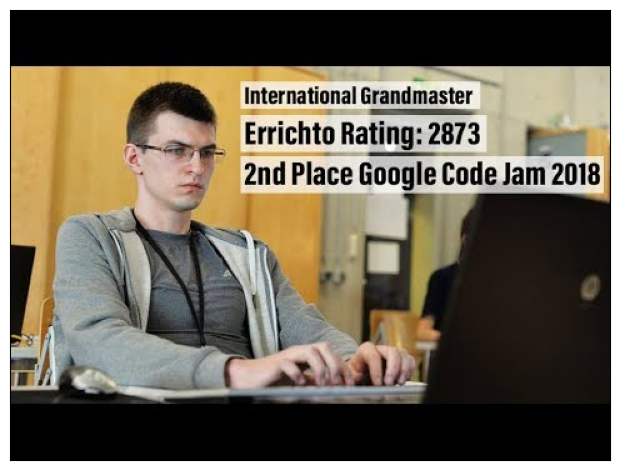

In [ ]:
idx = -1
path_to_img(ids[idx]['image'])
ids[idx]['title']

In [ ]:
titles = [section['title'] for section in ids]
paths = [section['image'] for section in ids]


In [ ]:
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
class CLIPDataset(torch.utils.data.Dataset):
  def __init__(self, titles, paths, tokenizer=tokenizer, transform=torchvision.transforms.CenterCrop(size=(80, 80))):
    super().__init__()
    self.titles = titles
    self.paths = paths
    assert len(self.titles) == len(self.paths), "Mis-matched lengths"

    self.tokenizer = tokenizer
    self.transform = transform

    # self.captions = list(captions)
    self.encoded_captions = tokenizer(
        list(titles), padding=True, truncation=True, max_length=100
    )

  def __len__(self):
    return len(self.titles)


  def __getitem__(self, idx):
    title, path = self.titles[idx], self.paths[idx]
    img = self.transform(read_image(path))

    item = {
        key: torch.tensor(values[idx])
        for key, values in self.encoded_captions.items()
    }

    item['image']=img


    return item




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# dataset = CLIPDataset(titles,paths)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Architectures


In [ ]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self,input):
        x = self.norm(input)
        qkv = self.to_qkv(x).chunk(3,dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class FeedForward(nn.Module):
  def __init__(self,dim, hidden_dim):
    super().__init__()
    self.network = nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, dim)
    )
  def forward(self, input):
    return self.network(input)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads, dim_head),
                FeedForward(dim, mlp_dim)
            ]))

    def forward(self, x):
      for (attn, ff) in self.layers:
        x = attn(x) + x
        x = ff(x) + x
      return self.norm(x)



class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)



In [ ]:
class TextEncoder(nn.Module):

    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]


In [ ]:
class Projection(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=.1):
        super().__init__()


        self.in_to_out = nn.Linear(in_dim, out_features=out_dim)
        self.fc = nn.Sequential(
            nn.GELU(),
            nn.Linear(out_dim, out_dim),
            nn.Dropout(dropout)
        )
        self.layer_norm = nn.LayerNorm(out_dim)

    def forward(self, input):
      input = self.in_to_out(input)
      x = self.fc(input) + input
      return self.layer_norm(x)

In [ ]:
from torch.nn.functional import softmax

class CLIP(nn.Module):
  def __init__(self):
    super().__init__()
    self.text_encoder = TextEncoder()
    self.image_encoder = ViT(
      channels=3,
      image_size=80,
      patch_size=8,
      num_classes=256,
      dim=64,
      depth=6,
      heads=8,
      mlp_dim=128,
      dropout=0.1,
      emb_dropout=0.1
    )
    self.temperature = 1.0

    self.text_projection = Projection(768, 200)
    self.vision_projection = Projection(256, 200)
    for param in self.text_encoder.parameters():
        param.requires_grad = False
    for param in self.image_encoder.parameters():
        param.requires_grad = False


  def forward(self, ids, attn, c):

    text_embedding = self.text_encoder(ids, attn)
    vision_embedding = self.image_encoder(c)
    text_multi = self.text_projection(text_embedding)
    vision_multi = self.vision_projection(vision_embedding)

    logits = (text_multi @ vision_multi.T) / self.temperature

    images_similarity = vision_multi @ vision_multi.T
    texts_similarity = text_multi @ text_multi.T

    targets = softmax(
        (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
    )

    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
    return loss.mean()

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()


In [ ]:
clip_model = CLIP()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# testing
# iteration = iter(dataloader)
# next = next(iteration)
# c = next['image'].to(dtype=torch.float32)
# ids = next['input_ids']
# attn = next['attention_mask']
# out = clip_model(ids, attn, c)

In [ ]:
# out

In [ ]:



!kaggle datasets download -d adityajn105/flickr8k
!unzip "flickr8k.zip"

def create_title_image_list(file_path):
    title_image_list = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        for line in lines:
            line = line.strip()
            split_up = line.split(',')
            if len(split_up)==2:
                image_path, title = split_up[0], split_up[1]
                title_image_list.append((title, f"./Images/{image_path}"))

    return title_image_list
data = create_title_image_list("captions.txt")
titles = [datum[0] for datum in data]
image_paths = [datum[1] for datum in data]
image_paths.pop(0)
titles.pop(0)


Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

'caption'

In [ ]:
import torch
import wandb
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from tqdm import tqdm

flickr_dataset = CLIPDataset(titles, image_paths)
flickr_dataloader = DataLoader(flickr_dataset, batch_size=32, shuffle=True)


# Training

In [ ]:
import torch
import wandb
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from tqdm import tqdm

wandb.init(project="CLIP")
wandb.config.dataset = "FlickR"

clip_model = CLIP()

optimizer = torch.optim.Adam(clip_model.parameters(), lr=1e-4)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = flickr_dataloader

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    clip_model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()

        # Extract data from batch
        c = batch['image'].to(dtype=torch.float32)
        ids = batch['input_ids']
        attn = batch['attention_mask']

        # Forward pass
        loss = clip_model(ids, attn, c)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        wandb.log({"Loss": loss.item()})
        print(loss.item())

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)

    # Log the loss to wandb
    # wandb.log({" Loss": avg_loss})


Epoch 1/1:   0%|          | 1/1188 [00:00<11:12,  1.77it/s]

14.15172290802002


Epoch 1/1:   0%|          | 2/1188 [00:00<08:09,  2.42it/s]

9.82325267791748


Epoch 1/1:   0%|          | 3/1188 [00:01<07:14,  2.73it/s]

10.875004768371582


Epoch 1/1:   0%|          | 4/1188 [00:01<06:36,  2.98it/s]

11.173789978027344


Epoch 1/1:   0%|          | 5/1188 [00:01<06:17,  3.13it/s]

8.681661605834961


Epoch 1/1:   1%|          | 6/1188 [00:02<06:02,  3.26it/s]

8.67867660522461


Epoch 1/1:   1%|          | 7/1188 [00:02<05:58,  3.30it/s]

7.8051371574401855


Epoch 1/1:   1%|          | 8/1188 [00:02<05:53,  3.34it/s]

9.573063850402832


Epoch 1/1:   1%|          | 9/1188 [00:02<05:46,  3.40it/s]

8.475109100341797


Epoch 1/1:   1%|          | 10/1188 [00:03<05:45,  3.41it/s]

8.02645206451416


Epoch 1/1:   1%|          | 11/1188 [00:03<05:53,  3.33it/s]

7.0386199951171875


Epoch 1/1:   1%|          | 12/1188 [00:03<05:46,  3.40it/s]

7.162874221801758


Epoch 1/1:   1%|          | 13/1188 [00:04<05:42,  3.44it/s]

8.43425178527832


Epoch 1/1:   1%|          | 14/1188 [00:04<05:41,  3.43it/s]

6.871425628662109


Epoch 1/1:   1%|▏         | 15/1188 [00:04<05:38,  3.46it/s]

8.228194236755371


Epoch 1/1:   1%|▏         | 16/1188 [00:04<05:40,  3.44it/s]

7.585229873657227


Epoch 1/1:   1%|▏         | 17/1188 [00:05<05:38,  3.46it/s]

7.637237071990967


Epoch 1/1:   2%|▏         | 18/1188 [00:05<05:37,  3.47it/s]

7.470989227294922


Epoch 1/1:   2%|▏         | 19/1188 [00:05<05:35,  3.48it/s]

7.9192728996276855


Epoch 1/1:   2%|▏         | 20/1188 [00:06<05:35,  3.48it/s]

6.595583915710449


Epoch 1/1:   2%|▏         | 21/1188 [00:06<05:38,  3.45it/s]

5.9688520431518555


Epoch 1/1:   2%|▏         | 22/1188 [00:06<05:36,  3.46it/s]

6.002793788909912


Epoch 1/1:   2%|▏         | 23/1188 [00:06<05:36,  3.46it/s]

6.1152567863464355


Epoch 1/1:   2%|▏         | 24/1188 [00:07<05:40,  3.42it/s]

6.678674221038818


Epoch 1/1:   2%|▏         | 25/1188 [00:07<06:25,  3.02it/s]

6.81348180770874


Epoch 1/1:   2%|▏         | 26/1188 [00:08<06:53,  2.81it/s]

6.354837894439697


Epoch 1/1:   2%|▏         | 27/1188 [00:08<07:16,  2.66it/s]

7.30545711517334


Epoch 1/1:   2%|▏         | 28/1188 [00:08<07:30,  2.58it/s]

6.731663227081299


Epoch 1/1:   2%|▏         | 29/1188 [00:09<07:39,  2.52it/s]

5.757978439331055


Epoch 1/1:   3%|▎         | 30/1188 [00:09<07:47,  2.48it/s]

5.693790435791016


Epoch 1/1:   3%|▎         | 31/1188 [00:10<07:53,  2.44it/s]

5.555569648742676


Epoch 1/1:   3%|▎         | 32/1188 [00:10<07:56,  2.43it/s]

5.758387565612793


Epoch 1/1:   3%|▎         | 33/1188 [00:11<07:58,  2.41it/s]

7.8472065925598145


Epoch 1/1:   3%|▎         | 34/1188 [00:11<08:00,  2.40it/s]

5.807034492492676


Epoch 1/1:   3%|▎         | 35/1188 [00:11<08:00,  2.40it/s]

5.569413185119629


Epoch 1/1:   3%|▎         | 36/1188 [00:12<08:01,  2.39it/s]

5.7861223220825195


Epoch 1/1:   3%|▎         | 37/1188 [00:12<08:00,  2.40it/s]

5.8866801261901855


Epoch 1/1:   3%|▎         | 38/1188 [00:13<07:20,  2.61it/s]

5.459548473358154


Epoch 1/1:   3%|▎         | 39/1188 [00:13<06:47,  2.82it/s]

5.194112777709961


Epoch 1/1:   3%|▎         | 40/1188 [00:13<06:26,  2.97it/s]

5.044212818145752


Epoch 1/1:   3%|▎         | 41/1188 [00:13<06:05,  3.14it/s]

6.306610107421875


Epoch 1/1:   4%|▎         | 42/1188 [00:14<05:53,  3.24it/s]

5.37591028213501


Epoch 1/1:   4%|▎         | 43/1188 [00:14<05:45,  3.31it/s]

4.969352722167969


Epoch 1/1:   4%|▎         | 44/1188 [00:14<05:45,  3.31it/s]

5.125200271606445


Epoch 1/1:   4%|▍         | 45/1188 [00:15<05:37,  3.39it/s]

5.803618907928467


Epoch 1/1:   4%|▍         | 46/1188 [00:15<05:32,  3.43it/s]

5.063016414642334


Epoch 1/1:   4%|▍         | 47/1188 [00:15<05:31,  3.44it/s]

5.12603759765625


Epoch 1/1:   4%|▍         | 48/1188 [00:15<05:32,  3.43it/s]

4.86073112487793


Epoch 1/1:   4%|▍         | 49/1188 [00:16<05:29,  3.46it/s]

4.955605506896973


Epoch 1/1:   4%|▍         | 50/1188 [00:16<05:25,  3.49it/s]

6.410923004150391


Epoch 1/1:   4%|▍         | 51/1188 [00:16<05:37,  3.37it/s]

5.677643775939941


Epoch 1/1:   4%|▍         | 52/1188 [00:17<05:33,  3.40it/s]

5.304683685302734


Epoch 1/1:   4%|▍         | 53/1188 [00:17<05:27,  3.46it/s]

5.487752914428711


Epoch 1/1:   5%|▍         | 54/1188 [00:17<05:26,  3.47it/s]

5.70754861831665


Epoch 1/1:   5%|▍         | 55/1188 [00:17<05:25,  3.48it/s]

5.099816799163818


Epoch 1/1:   5%|▍         | 56/1188 [00:18<05:24,  3.48it/s]

5.340958118438721


Epoch 1/1:   5%|▍         | 57/1188 [00:18<05:23,  3.50it/s]

4.931087017059326


Epoch 1/1:   5%|▍         | 58/1188 [00:18<05:37,  3.35it/s]

4.989689826965332


Epoch 1/1:   5%|▍         | 59/1188 [00:19<05:33,  3.38it/s]

5.16392183303833


Epoch 1/1:   5%|▌         | 60/1188 [00:19<05:28,  3.43it/s]

4.729630947113037


Epoch 1/1:   5%|▌         | 61/1188 [00:19<05:26,  3.45it/s]

4.778677463531494


Epoch 1/1:   5%|▌         | 62/1188 [00:19<05:34,  3.36it/s]

4.526163101196289


Epoch 1/1:   5%|▌         | 63/1188 [00:20<05:36,  3.35it/s]

4.947032928466797


Epoch 1/1:   5%|▌         | 64/1188 [00:20<05:31,  3.39it/s]

4.807906150817871


Epoch 1/1:   5%|▌         | 65/1188 [00:20<05:30,  3.40it/s]

4.701713562011719


Epoch 1/1:   6%|▌         | 66/1188 [00:21<05:25,  3.45it/s]

5.069250106811523


Epoch 1/1:   6%|▌         | 67/1188 [00:21<05:24,  3.45it/s]

5.5189666748046875


Epoch 1/1:   6%|▌         | 68/1188 [00:21<05:20,  3.49it/s]

4.77577018737793


Epoch 1/1:   6%|▌         | 69/1188 [00:22<05:20,  3.49it/s]

5.080482482910156


Epoch 1/1:   6%|▌         | 70/1188 [00:22<05:24,  3.44it/s]

4.504297256469727


Epoch 1/1:   6%|▌         | 71/1188 [00:22<05:21,  3.48it/s]

4.782538890838623


Epoch 1/1:   6%|▌         | 72/1188 [00:22<05:39,  3.28it/s]

5.336101055145264


Epoch 1/1:   6%|▌         | 73/1188 [00:23<05:49,  3.19it/s]

4.801638126373291


Epoch 1/1:   6%|▌         | 74/1188 [00:23<05:56,  3.13it/s]

4.666686058044434


Epoch 1/1:   6%|▋         | 75/1188 [00:23<06:04,  3.06it/s]

5.0154924392700195


Epoch 1/1:   6%|▋         | 76/1188 [00:24<06:04,  3.05it/s]

4.91599178314209


Epoch 1/1:   6%|▋         | 77/1188 [00:24<06:30,  2.85it/s]

4.5895538330078125


Epoch 1/1:   7%|▋         | 78/1188 [00:25<06:50,  2.70it/s]

4.52413272857666


Epoch 1/1:   7%|▋         | 79/1188 [00:25<07:03,  2.62it/s]

4.72532844543457


Epoch 1/1:   7%|▋         | 80/1188 [00:25<07:12,  2.56it/s]

4.585710525512695


Epoch 1/1:   7%|▋         | 81/1188 [00:26<07:16,  2.54it/s]

4.2248005867004395


Epoch 1/1:   7%|▋         | 82/1188 [00:26<07:21,  2.50it/s]

4.306587219238281


Epoch 1/1:   7%|▋         | 83/1188 [00:27<07:33,  2.44it/s]

4.560113430023193


Epoch 1/1:   7%|▋         | 84/1188 [00:27<07:32,  2.44it/s]

4.702121257781982


Epoch 1/1:   7%|▋         | 85/1188 [00:27<07:34,  2.43it/s]

4.443103313446045


Epoch 1/1:   7%|▋         | 86/1188 [00:28<07:33,  2.43it/s]

4.416327476501465


Epoch 1/1:   7%|▋         | 87/1188 [00:28<07:13,  2.54it/s]

4.6969757080078125


Epoch 1/1:   7%|▋         | 88/1188 [00:29<06:42,  2.73it/s]

4.592496871948242


Epoch 1/1:   7%|▋         | 89/1188 [00:29<06:14,  2.94it/s]

4.437869548797607


Epoch 1/1:   8%|▊         | 90/1188 [00:29<05:55,  3.09it/s]

4.044261932373047


Epoch 1/1:   8%|▊         | 91/1188 [00:29<05:42,  3.20it/s]

4.273521900177002


Epoch 1/1:   8%|▊         | 92/1188 [00:30<05:40,  3.22it/s]

4.7381792068481445


Epoch 1/1:   8%|▊         | 93/1188 [00:30<05:31,  3.30it/s]

4.803164958953857


Epoch 1/1:   8%|▊         | 94/1188 [00:30<05:24,  3.37it/s]

4.207234859466553


Epoch 1/1:   8%|▊         | 95/1188 [00:31<05:20,  3.41it/s]

4.481093406677246


Epoch 1/1:   8%|▊         | 96/1188 [00:31<05:15,  3.46it/s]

4.595000743865967


Epoch 1/1:   8%|▊         | 97/1188 [00:31<05:15,  3.46it/s]

4.073079586029053


Epoch 1/1:   8%|▊         | 98/1188 [00:31<05:15,  3.46it/s]

4.645205974578857


Epoch 1/1:   8%|▊         | 99/1188 [00:32<05:18,  3.42it/s]

4.951069355010986


Epoch 1/1:   8%|▊         | 100/1188 [00:32<05:13,  3.47it/s]

4.367784023284912


Epoch 1/1:   9%|▊         | 101/1188 [00:32<05:10,  3.50it/s]

4.261946201324463


Epoch 1/1:   9%|▊         | 102/1188 [00:33<05:10,  3.50it/s]

4.435389041900635


Epoch 1/1:   9%|▊         | 103/1188 [00:33<05:13,  3.47it/s]

4.219231605529785


Epoch 1/1:   9%|▉         | 104/1188 [00:33<05:12,  3.47it/s]

4.2355828285217285


Epoch 1/1:   9%|▉         | 105/1188 [00:33<05:08,  3.51it/s]

4.6477274894714355


Epoch 1/1:   9%|▉         | 106/1188 [00:34<05:09,  3.50it/s]

4.210704803466797


Epoch 1/1:   9%|▉         | 107/1188 [00:34<05:09,  3.50it/s]

4.160472869873047


Epoch 1/1:   9%|▉         | 108/1188 [00:34<05:07,  3.52it/s]

4.343291759490967


Epoch 1/1:   9%|▉         | 109/1188 [00:35<05:06,  3.52it/s]

4.62983512878418


Epoch 1/1:   9%|▉         | 110/1188 [00:35<05:08,  3.49it/s]

4.220774173736572


Epoch 1/1:   9%|▉         | 111/1188 [00:35<05:05,  3.52it/s]

4.312846660614014


Epoch 1/1:   9%|▉         | 112/1188 [00:35<05:20,  3.35it/s]

4.0712809562683105


Epoch 1/1:  10%|▉         | 113/1188 [00:36<05:38,  3.17it/s]

4.21425199508667


Epoch 1/1:  10%|▉         | 114/1188 [00:36<05:48,  3.08it/s]

4.4780120849609375


Epoch 1/1:  10%|▉         | 115/1188 [00:37<05:53,  3.03it/s]

4.099885940551758


Epoch 1/1:  10%|▉         | 116/1188 [00:37<05:57,  3.00it/s]

4.858953475952148


Epoch 1/1:  10%|▉         | 117/1188 [00:37<06:05,  2.93it/s]

4.1666717529296875


Epoch 1/1:  10%|▉         | 118/1188 [00:38<06:27,  2.76it/s]

4.243268966674805


Epoch 1/1:  10%|█         | 119/1188 [00:38<06:22,  2.79it/s]

4.415347576141357


Epoch 1/1:  10%|█         | 120/1188 [00:38<06:39,  2.67it/s]

4.325263977050781


Epoch 1/1:  10%|█         | 121/1188 [00:39<06:50,  2.60it/s]

4.207115650177002


Epoch 1/1:  10%|█         | 122/1188 [00:39<07:00,  2.54it/s]

4.128682613372803


Epoch 1/1:  10%|█         | 123/1188 [00:40<07:09,  2.48it/s]

4.374880313873291


Epoch 1/1:  10%|█         | 124/1188 [00:40<07:14,  2.45it/s]

4.076577186584473


Epoch 1/1:  11%|█         | 125/1188 [00:40<07:16,  2.44it/s]

4.2629008293151855


Epoch 1/1:  11%|█         | 126/1188 [00:41<07:20,  2.41it/s]

4.332114219665527


Epoch 1/1:  11%|█         | 127/1188 [00:41<07:23,  2.39it/s]

3.9828624725341797


Epoch 1/1:  11%|█         | 128/1188 [00:42<07:28,  2.36it/s]

4.006019592285156


Epoch 1/1:  11%|█         | 129/1188 [00:42<07:43,  2.29it/s]

4.261970043182373


Epoch 1/1:  11%|█         | 130/1188 [00:43<07:35,  2.32it/s]

4.074704170227051


Epoch 1/1:  11%|█         | 131/1188 [00:43<07:34,  2.33it/s]

3.930258274078369


Epoch 1/1:  11%|█         | 132/1188 [00:44<07:39,  2.30it/s]

4.186836242675781


Epoch 1/1:  11%|█         | 133/1188 [00:44<07:37,  2.31it/s]

4.296990394592285


Epoch 1/1:  11%|█▏        | 134/1188 [00:44<07:31,  2.34it/s]

4.065193176269531


Epoch 1/1:  11%|█▏        | 135/1188 [00:45<07:26,  2.36it/s]

4.0815558433532715


Epoch 1/1:  11%|█▏        | 136/1188 [00:45<07:27,  2.35it/s]

4.186667442321777


Epoch 1/1:  12%|█▏        | 137/1188 [00:46<07:24,  2.37it/s]

3.9323580265045166


Epoch 1/1:  12%|█▏        | 138/1188 [00:46<07:03,  2.48it/s]

4.375698566436768


Epoch 1/1:  12%|█▏        | 139/1188 [00:46<06:46,  2.58it/s]

4.09969425201416


Epoch 1/1:  12%|█▏        | 140/1188 [00:47<06:57,  2.51it/s]

3.9993951320648193


Epoch 1/1:  12%|█▏        | 141/1188 [00:47<07:02,  2.48it/s]

4.000298023223877


Epoch 1/1:  12%|█▏        | 142/1188 [00:48<07:13,  2.41it/s]

4.114006519317627


Epoch 1/1:  12%|█▏        | 143/1188 [00:48<07:16,  2.39it/s]

4.082920551300049


Epoch 1/1:  12%|█▏        | 144/1188 [00:48<06:45,  2.57it/s]

4.207200050354004


Epoch 1/1:  12%|█▏        | 145/1188 [00:49<06:20,  2.74it/s]

3.950639247894287


Epoch 1/1:  12%|█▏        | 146/1188 [00:49<06:03,  2.87it/s]

4.08232307434082


Epoch 1/1:  12%|█▏        | 147/1188 [00:49<05:44,  3.02it/s]

3.948671579360962


Epoch 1/1:  12%|█▏        | 148/1188 [00:50<05:29,  3.16it/s]

4.262973785400391


Epoch 1/1:  13%|█▎        | 149/1188 [00:50<05:19,  3.26it/s]

4.089804649353027


Epoch 1/1:  13%|█▎        | 150/1188 [00:50<05:11,  3.33it/s]

4.395377159118652


Epoch 1/1:  13%|█▎        | 151/1188 [00:50<05:08,  3.36it/s]

4.023283004760742


Epoch 1/1:  13%|█▎        | 152/1188 [00:51<05:03,  3.42it/s]

4.227956771850586


Epoch 1/1:  13%|█▎        | 153/1188 [00:51<04:58,  3.47it/s]

3.7174034118652344


Epoch 1/1:  13%|█▎        | 154/1188 [00:51<05:17,  3.26it/s]

4.1287522315979


Epoch 1/1:  13%|█▎        | 155/1188 [00:52<05:30,  3.13it/s]

3.987753391265869


Epoch 1/1:  13%|█▎        | 156/1188 [00:52<05:38,  3.05it/s]

4.123705863952637


Epoch 1/1:  13%|█▎        | 157/1188 [00:52<05:46,  2.97it/s]

4.209567546844482


Epoch 1/1:  13%|█▎        | 158/1188 [00:53<06:11,  2.77it/s]

4.006761074066162


Epoch 1/1:  13%|█▎        | 159/1188 [00:53<06:31,  2.63it/s]

4.260951519012451


Epoch 1/1:  13%|█▎        | 160/1188 [00:54<06:43,  2.55it/s]

4.227862358093262


Epoch 1/1:  14%|█▎        | 161/1188 [00:54<06:50,  2.50it/s]

3.861093759536743


Epoch 1/1:  14%|█▎        | 162/1188 [00:54<06:58,  2.45it/s]

4.412915229797363


Epoch 1/1:  14%|█▎        | 163/1188 [00:55<07:00,  2.44it/s]

4.236851215362549


Epoch 1/1:  14%|█▍        | 164/1188 [00:55<07:01,  2.43it/s]

4.196610927581787


Epoch 1/1:  14%|█▍        | 165/1188 [00:56<07:01,  2.43it/s]

3.926913022994995


Epoch 1/1:  14%|█▍        | 166/1188 [00:56<07:02,  2.42it/s]

3.8208653926849365


Epoch 1/1:  14%|█▍        | 167/1188 [00:57<07:03,  2.41it/s]

4.1206583976745605


Epoch 1/1:  14%|█▍        | 168/1188 [00:57<07:03,  2.41it/s]

4.000380992889404


Epoch 1/1:  14%|█▍        | 169/1188 [00:57<07:05,  2.40it/s]

4.033624172210693


Epoch 1/1:  14%|█▍        | 170/1188 [00:58<07:09,  2.37it/s]

4.225476264953613


Epoch 1/1:  14%|█▍        | 171/1188 [00:58<07:11,  2.35it/s]

3.9256539344787598


Epoch 1/1:  14%|█▍        | 172/1188 [00:59<07:15,  2.33it/s]

4.102244853973389


Epoch 1/1:  15%|█▍        | 173/1188 [00:59<07:08,  2.37it/s]

4.11475133895874


Epoch 1/1:  15%|█▍        | 174/1188 [00:59<06:45,  2.50it/s]

4.1516337394714355


Epoch 1/1:  15%|█▍        | 175/1188 [01:00<06:14,  2.70it/s]

3.8677361011505127


Epoch 1/1:  15%|█▍        | 176/1188 [01:00<05:47,  2.91it/s]

3.8250508308410645


Epoch 1/1:  15%|█▍        | 177/1188 [01:00<05:31,  3.05it/s]

4.011754512786865


Epoch 1/1:  15%|█▍        | 178/1188 [01:01<05:18,  3.17it/s]

4.004281997680664


Epoch 1/1:  15%|█▌        | 179/1188 [01:01<05:09,  3.26it/s]

3.9763376712799072


Epoch 1/1:  15%|█▌        | 180/1188 [01:01<05:01,  3.34it/s]

3.7875149250030518


Epoch 1/1:  15%|█▌        | 181/1188 [01:01<04:55,  3.40it/s]

3.990845203399658


Epoch 1/1:  15%|█▌        | 182/1188 [01:02<04:55,  3.40it/s]

3.9774599075317383


Epoch 1/1:  15%|█▌        | 183/1188 [01:02<04:50,  3.46it/s]

3.674715518951416


Epoch 1/1:  15%|█▌        | 184/1188 [01:02<04:51,  3.45it/s]

3.9855258464813232


Epoch 1/1:  16%|█▌        | 185/1188 [01:03<04:49,  3.46it/s]

3.918689012527466


Epoch 1/1:  16%|█▌        | 186/1188 [01:03<04:50,  3.45it/s]

3.855719804763794


Epoch 1/1:  16%|█▌        | 187/1188 [01:03<04:49,  3.46it/s]

3.9594664573669434


Epoch 1/1:  16%|█▌        | 188/1188 [01:03<04:46,  3.49it/s]

3.994246006011963


Epoch 1/1:  16%|█▌        | 189/1188 [01:04<04:47,  3.48it/s]

4.113686561584473


Epoch 1/1:  16%|█▌        | 190/1188 [01:04<04:51,  3.42it/s]

3.835822105407715


Epoch 1/1:  16%|█▌        | 191/1188 [01:04<05:08,  3.23it/s]

3.8419785499572754


Epoch 1/1:  16%|█▌        | 192/1188 [01:05<05:18,  3.12it/s]

3.829967737197876


Epoch 1/1:  16%|█▌        | 193/1188 [01:05<05:25,  3.06it/s]

4.173969268798828


Epoch 1/1:  16%|█▋        | 194/1188 [01:05<05:34,  2.97it/s]

4.030881404876709


Epoch 1/1:  16%|█▋        | 195/1188 [01:06<05:40,  2.92it/s]

3.9857115745544434


Epoch 1/1:  16%|█▋        | 196/1188 [01:06<05:39,  2.92it/s]

4.0176472663879395


Epoch 1/1:  17%|█▋        | 197/1188 [01:07<05:43,  2.88it/s]

3.8275742530822754


Epoch 1/1:  17%|█▋        | 198/1188 [01:07<05:44,  2.88it/s]

3.8160715103149414


Epoch 1/1:  17%|█▋        | 199/1188 [01:07<05:43,  2.88it/s]

3.9701390266418457


Epoch 1/1:  17%|█▋        | 200/1188 [01:08<05:42,  2.89it/s]

4.122884273529053


Epoch 1/1:  17%|█▋        | 201/1188 [01:08<05:42,  2.88it/s]

3.808286666870117


Epoch 1/1:  17%|█▋        | 202/1188 [01:08<05:42,  2.88it/s]

3.8228867053985596


Epoch 1/1:  17%|█▋        | 203/1188 [01:09<05:43,  2.87it/s]

3.8029701709747314


Epoch 1/1:  17%|█▋        | 204/1188 [01:09<05:41,  2.88it/s]

3.8571572303771973


Epoch 1/1:  17%|█▋        | 205/1188 [01:09<05:40,  2.89it/s]

3.7523891925811768


Epoch 1/1:  17%|█▋        | 206/1188 [01:10<05:51,  2.80it/s]

3.7800536155700684


Epoch 1/1:  17%|█▋        | 207/1188 [01:10<05:53,  2.77it/s]

3.775766372680664


Epoch 1/1:  18%|█▊        | 208/1188 [01:10<05:45,  2.83it/s]

3.9971742630004883


Epoch 1/1:  18%|█▊        | 209/1188 [01:11<05:40,  2.88it/s]

3.9658889770507812


Epoch 1/1:  18%|█▊        | 210/1188 [01:11<05:34,  2.92it/s]

3.79719877243042


Epoch 1/1:  18%|█▊        | 211/1188 [01:11<05:34,  2.92it/s]

4.0067267417907715


Epoch 1/1:  18%|█▊        | 212/1188 [01:12<05:58,  2.72it/s]

3.7022194862365723


Epoch 1/1:  18%|█▊        | 213/1188 [01:12<06:10,  2.63it/s]

4.183514595031738


Epoch 1/1:  18%|█▊        | 214/1188 [01:13<06:18,  2.57it/s]

4.1216936111450195


Epoch 1/1:  18%|█▊        | 215/1188 [01:13<06:27,  2.51it/s]

4.075032711029053


Epoch 1/1:  18%|█▊        | 216/1188 [01:13<06:32,  2.48it/s]

3.9658868312835693


Epoch 1/1:  18%|█▊        | 217/1188 [01:14<06:37,  2.44it/s]

3.8687081336975098


Epoch 1/1:  18%|█▊        | 218/1188 [01:14<06:42,  2.41it/s]

3.7089688777923584


Epoch 1/1:  18%|█▊        | 219/1188 [01:15<06:43,  2.40it/s]

3.808960437774658


Epoch 1/1:  19%|█▊        | 220/1188 [01:15<06:42,  2.41it/s]

4.012530326843262


Epoch 1/1:  19%|█▊        | 221/1188 [01:16<06:41,  2.41it/s]

3.797398090362549


Epoch 1/1:  19%|█▊        | 222/1188 [01:16<06:44,  2.39it/s]

3.595839262008667


Epoch 1/1:  19%|█▉        | 223/1188 [01:16<06:41,  2.40it/s]

3.7642855644226074


Epoch 1/1:  19%|█▉        | 224/1188 [01:17<06:44,  2.39it/s]

3.8424272537231445


Epoch 1/1:  19%|█▉        | 225/1188 [01:17<06:43,  2.39it/s]

3.7478480339050293


Epoch 1/1:  19%|█▉        | 226/1188 [01:18<06:42,  2.39it/s]

3.685406446456909


Epoch 1/1:  19%|█▉        | 227/1188 [01:18<06:41,  2.40it/s]

3.921299934387207


Epoch 1/1:  19%|█▉        | 228/1188 [01:18<06:40,  2.40it/s]

3.9573800563812256


Epoch 1/1:  19%|█▉        | 229/1188 [01:19<06:38,  2.41it/s]

3.820704936981201


Epoch 1/1:  19%|█▉        | 230/1188 [01:19<06:07,  2.61it/s]

3.8102588653564453


Epoch 1/1:  19%|█▉        | 231/1188 [01:20<05:46,  2.76it/s]

3.9600510597229004


Epoch 1/1:  20%|█▉        | 232/1188 [01:20<05:23,  2.95it/s]

3.8621420860290527


Epoch 1/1:  20%|█▉        | 233/1188 [01:20<05:06,  3.11it/s]

3.8037068843841553


Epoch 1/1:  20%|█▉        | 234/1188 [01:20<04:57,  3.21it/s]

3.8817620277404785


Epoch 1/1:  20%|█▉        | 235/1188 [01:21<04:47,  3.31it/s]

3.992889642715454


Epoch 1/1:  20%|█▉        | 236/1188 [01:21<04:42,  3.37it/s]

3.8640377521514893


Epoch 1/1:  20%|█▉        | 237/1188 [01:21<04:37,  3.42it/s]

3.7437989711761475


Epoch 1/1:  20%|██        | 238/1188 [01:22<04:38,  3.41it/s]

3.745028018951416


Epoch 1/1:  20%|██        | 239/1188 [01:22<04:36,  3.43it/s]

3.7684922218322754


Epoch 1/1:  20%|██        | 240/1188 [01:22<04:33,  3.46it/s]

3.7768192291259766


Epoch 1/1:  20%|██        | 241/1188 [01:22<04:32,  3.47it/s]

3.782146453857422


Epoch 1/1:  20%|██        | 242/1188 [01:23<04:30,  3.49it/s]

3.771994113922119


Epoch 1/1:  20%|██        | 243/1188 [01:23<04:30,  3.49it/s]

3.7488882541656494


Epoch 1/1:  21%|██        | 244/1188 [01:23<04:27,  3.53it/s]

3.4011950492858887


Epoch 1/1:  21%|██        | 245/1188 [01:24<04:33,  3.44it/s]

3.645813465118408


Epoch 1/1:  21%|██        | 246/1188 [01:24<04:32,  3.46it/s]

3.8943419456481934


Epoch 1/1:  21%|██        | 247/1188 [01:24<04:29,  3.49it/s]

3.802415132522583


Epoch 1/1:  21%|██        | 248/1188 [01:24<04:27,  3.51it/s]

3.9302704334259033


Epoch 1/1:  21%|██        | 249/1188 [01:25<04:25,  3.54it/s]

3.4639580249786377


Epoch 1/1:  21%|██        | 250/1188 [01:25<04:26,  3.51it/s]

3.6920995712280273


Epoch 1/1:  21%|██        | 251/1188 [01:25<04:25,  3.53it/s]

3.82127046585083


Epoch 1/1:  21%|██        | 252/1188 [01:26<04:41,  3.32it/s]

3.8099377155303955


Epoch 1/1:  21%|██▏       | 253/1188 [01:26<04:52,  3.20it/s]

4.006787300109863


Epoch 1/1:  21%|██▏       | 254/1188 [01:26<04:59,  3.12it/s]

3.911823034286499


Epoch 1/1:  21%|██▏       | 255/1188 [01:27<05:03,  3.08it/s]

3.722054958343506


Epoch 1/1:  22%|██▏       | 256/1188 [01:27<05:06,  3.04it/s]

3.9478979110717773


Epoch 1/1:  22%|██▏       | 257/1188 [01:27<05:29,  2.82it/s]

3.8043198585510254


Epoch 1/1:  22%|██▏       | 258/1188 [01:28<05:45,  2.69it/s]

4.043792724609375


Epoch 1/1:  22%|██▏       | 259/1188 [01:28<05:56,  2.61it/s]

3.7206552028656006


Epoch 1/1:  22%|██▏       | 260/1188 [01:29<06:05,  2.54it/s]

3.739368438720703


Epoch 1/1:  22%|██▏       | 261/1188 [01:29<06:09,  2.51it/s]

3.6363697052001953


Epoch 1/1:  22%|██▏       | 262/1188 [01:29<06:15,  2.46it/s]

3.877335548400879


Epoch 1/1:  22%|██▏       | 263/1188 [01:30<06:26,  2.40it/s]

3.8965744972229004


Epoch 1/1:  22%|██▏       | 264/1188 [01:30<06:26,  2.39it/s]

3.873006820678711


Epoch 1/1:  22%|██▏       | 265/1188 [01:31<06:23,  2.41it/s]

3.721926689147949


Epoch 1/1:  22%|██▏       | 266/1188 [01:31<06:30,  2.36it/s]

3.7776432037353516


Epoch 1/1:  22%|██▏       | 267/1188 [01:31<06:07,  2.51it/s]

3.553804874420166


Epoch 1/1:  23%|██▎       | 268/1188 [01:32<05:45,  2.66it/s]

3.6596593856811523


Epoch 1/1:  23%|██▎       | 269/1188 [01:32<05:22,  2.85it/s]

3.8653717041015625


Epoch 1/1:  23%|██▎       | 270/1188 [01:32<05:03,  3.02it/s]

3.797373056411743


Epoch 1/1:  23%|██▎       | 271/1188 [01:33<04:49,  3.16it/s]

3.791459083557129


Epoch 1/1:  23%|██▎       | 272/1188 [01:33<04:51,  3.14it/s]

3.7840914726257324


Epoch 1/1:  23%|██▎       | 273/1188 [01:33<04:41,  3.25it/s]

3.8018083572387695


Epoch 1/1:  23%|██▎       | 274/1188 [01:34<04:36,  3.31it/s]

3.764446973800659


Epoch 1/1:  23%|██▎       | 275/1188 [01:34<04:34,  3.33it/s]

3.7427561283111572


Epoch 1/1:  23%|██▎       | 276/1188 [01:34<04:29,  3.38it/s]

3.7805137634277344


Epoch 1/1:  23%|██▎       | 277/1188 [01:34<04:27,  3.40it/s]

3.434063673019409


Epoch 1/1:  23%|██▎       | 278/1188 [01:35<04:24,  3.44it/s]

3.771078109741211


Epoch 1/1:  23%|██▎       | 279/1188 [01:35<04:23,  3.45it/s]

3.6910696029663086


Epoch 1/1:  24%|██▎       | 280/1188 [01:35<04:21,  3.47it/s]

3.658221960067749


Epoch 1/1:  24%|██▎       | 281/1188 [01:36<04:21,  3.47it/s]

3.6990926265716553


Epoch 1/1:  24%|██▎       | 282/1188 [01:36<04:21,  3.47it/s]

3.913936138153076


Epoch 1/1:  24%|██▍       | 283/1188 [01:36<04:18,  3.50it/s]

3.7704124450683594


Epoch 1/1:  24%|██▍       | 284/1188 [01:36<04:17,  3.51it/s]

3.6761813163757324


Epoch 1/1:  24%|██▍       | 285/1188 [01:37<04:18,  3.49it/s]

3.77917218208313


Epoch 1/1:  24%|██▍       | 286/1188 [01:37<04:19,  3.48it/s]

3.6683928966522217


Epoch 1/1:  24%|██▍       | 287/1188 [01:37<04:19,  3.47it/s]

3.6882095336914062


Epoch 1/1:  24%|██▍       | 288/1188 [01:38<04:18,  3.48it/s]

3.608985185623169


Epoch 1/1:  24%|██▍       | 289/1188 [01:38<04:16,  3.51it/s]

3.73953914642334


Epoch 1/1:  24%|██▍       | 290/1188 [01:38<04:17,  3.49it/s]

3.6429080963134766


Epoch 1/1:  24%|██▍       | 291/1188 [01:38<04:16,  3.49it/s]

3.7651729583740234


Epoch 1/1:  25%|██▍       | 292/1188 [01:39<04:16,  3.50it/s]

3.792752981185913


Epoch 1/1:  25%|██▍       | 293/1188 [01:39<04:18,  3.46it/s]

3.6369917392730713


Epoch 1/1:  25%|██▍       | 294/1188 [01:39<04:19,  3.45it/s]

3.6805036067962646


Epoch 1/1:  25%|██▍       | 295/1188 [01:40<04:19,  3.44it/s]

3.65303373336792


Epoch 1/1:  25%|██▍       | 296/1188 [01:40<04:19,  3.44it/s]

3.6604347229003906


Epoch 1/1:  25%|██▌       | 297/1188 [01:40<04:18,  3.44it/s]

3.6246981620788574


Epoch 1/1:  25%|██▌       | 298/1188 [01:40<04:18,  3.45it/s]

3.714578151702881


Epoch 1/1:  25%|██▌       | 299/1188 [01:41<04:15,  3.48it/s]

3.7833430767059326


Epoch 1/1:  25%|██▌       | 300/1188 [01:41<04:15,  3.48it/s]

3.714181900024414


Epoch 1/1:  25%|██▌       | 301/1188 [01:41<04:19,  3.41it/s]

3.676764488220215


Epoch 1/1:  25%|██▌       | 302/1188 [01:42<04:28,  3.29it/s]

3.699212074279785


Epoch 1/1:  26%|██▌       | 303/1188 [01:42<04:36,  3.20it/s]

3.647103786468506


Epoch 1/1:  26%|██▌       | 304/1188 [01:42<04:46,  3.09it/s]

3.608842372894287


Epoch 1/1:  26%|██▌       | 305/1188 [01:43<04:48,  3.06it/s]

3.5589146614074707


Epoch 1/1:  26%|██▌       | 306/1188 [01:43<04:49,  3.05it/s]

3.894775867462158


Epoch 1/1:  26%|██▌       | 307/1188 [01:43<05:11,  2.83it/s]

3.7377002239227295


Epoch 1/1:  26%|██▌       | 308/1188 [01:44<05:31,  2.65it/s]

3.6550729274749756


Epoch 1/1:  26%|██▌       | 309/1188 [01:44<05:45,  2.54it/s]

3.6670072078704834


Epoch 1/1:  26%|██▌       | 310/1188 [01:45<05:50,  2.50it/s]

3.794870376586914


Epoch 1/1:  26%|██▌       | 311/1188 [01:45<05:53,  2.48it/s]

3.681952953338623


Epoch 1/1:  26%|██▋       | 312/1188 [01:46<05:57,  2.45it/s]

3.8011531829833984


Epoch 1/1:  26%|██▋       | 313/1188 [01:46<06:00,  2.43it/s]

3.56361985206604


Epoch 1/1:  26%|██▋       | 314/1188 [01:46<06:08,  2.37it/s]

3.7695441246032715


Epoch 1/1:  27%|██▋       | 315/1188 [01:47<06:05,  2.39it/s]

3.555804967880249


Epoch 1/1:  27%|██▋       | 316/1188 [01:47<06:04,  2.39it/s]

3.8575124740600586


Epoch 1/1:  27%|██▋       | 317/1188 [01:48<05:53,  2.47it/s]

3.6670775413513184


Epoch 1/1:  27%|██▋       | 318/1188 [01:48<05:20,  2.71it/s]

3.6996004581451416


Epoch 1/1:  27%|██▋       | 319/1188 [01:48<04:57,  2.92it/s]

3.8009941577911377


Epoch 1/1:  27%|██▋       | 320/1188 [01:48<04:41,  3.08it/s]

3.7480292320251465


Epoch 1/1:  27%|██▋       | 321/1188 [01:49<04:30,  3.21it/s]

3.7101616859436035


Epoch 1/1:  27%|██▋       | 322/1188 [01:49<04:22,  3.30it/s]

3.743936061859131


Epoch 1/1:  27%|██▋       | 323/1188 [01:49<04:18,  3.34it/s]

3.6567208766937256


Epoch 1/1:  27%|██▋       | 324/1188 [01:50<04:14,  3.39it/s]

3.8102829456329346


Epoch 1/1:  27%|██▋       | 325/1188 [01:50<04:16,  3.36it/s]

3.5925071239471436


Epoch 1/1:  27%|██▋       | 326/1188 [01:50<04:11,  3.43it/s]

3.6933014392852783


Epoch 1/1:  28%|██▊       | 327/1188 [01:50<04:21,  3.30it/s]

3.7709312438964844


Epoch 1/1:  28%|██▊       | 328/1188 [01:51<04:31,  3.16it/s]

3.8123414516448975


Epoch 1/1:  28%|██▊       | 329/1188 [01:51<04:42,  3.04it/s]

3.6997549533843994


Epoch 1/1:  28%|██▊       | 330/1188 [01:52<04:51,  2.95it/s]

3.7876763343811035


Epoch 1/1:  28%|██▊       | 331/1188 [01:52<04:54,  2.91it/s]

3.7229316234588623


Epoch 1/1:  28%|██▊       | 332/1188 [01:52<04:56,  2.89it/s]

3.708843231201172


Epoch 1/1:  28%|██▊       | 333/1188 [01:53<05:00,  2.85it/s]

3.520446300506592


Epoch 1/1:  28%|██▊       | 334/1188 [01:53<05:13,  2.72it/s]

3.610883951187134


Epoch 1/1:  28%|██▊       | 335/1188 [01:53<05:23,  2.63it/s]

3.6350667476654053


Epoch 1/1:  28%|██▊       | 336/1188 [01:54<05:32,  2.56it/s]

3.963193416595459


Epoch 1/1:  28%|██▊       | 337/1188 [01:54<05:38,  2.51it/s]

3.6698474884033203


Epoch 1/1:  28%|██▊       | 338/1188 [01:55<05:43,  2.47it/s]

3.775149345397949


Epoch 1/1:  29%|██▊       | 339/1188 [01:55<05:42,  2.48it/s]

3.4182260036468506


Epoch 1/1:  29%|██▊       | 340/1188 [01:55<05:31,  2.55it/s]

3.4796204566955566


Epoch 1/1:  29%|██▊       | 341/1188 [01:56<05:21,  2.63it/s]

3.6353394985198975


Epoch 1/1:  29%|██▉       | 342/1188 [01:56<05:15,  2.68it/s]

3.5595996379852295


Epoch 1/1:  29%|██▉       | 343/1188 [01:57<05:09,  2.73it/s]

3.7918920516967773


Epoch 1/1:  29%|██▉       | 344/1188 [01:57<05:11,  2.71it/s]

3.6887590885162354


Epoch 1/1:  29%|██▉       | 345/1188 [01:57<05:23,  2.61it/s]

3.6706299781799316


Epoch 1/1:  29%|██▉       | 346/1188 [01:58<05:34,  2.52it/s]

3.8282015323638916


Epoch 1/1:  29%|██▉       | 347/1188 [01:58<05:35,  2.51it/s]

3.711848497390747


Epoch 1/1:  29%|██▉       | 348/1188 [01:59<05:37,  2.49it/s]

3.729583263397217


Epoch 1/1:  29%|██▉       | 349/1188 [01:59<05:40,  2.47it/s]

3.6985299587249756


Epoch 1/1:  29%|██▉       | 350/1188 [01:59<05:44,  2.44it/s]

3.6272778511047363


Epoch 1/1:  30%|██▉       | 351/1188 [02:00<05:55,  2.36it/s]

3.6484158039093018


Epoch 1/1:  30%|██▉       | 352/1188 [02:00<05:52,  2.37it/s]

3.5831458568573


Epoch 1/1:  30%|██▉       | 353/1188 [02:01<05:56,  2.34it/s]

3.638434886932373


Epoch 1/1:  30%|██▉       | 354/1188 [02:01<05:50,  2.38it/s]

3.665231704711914


Epoch 1/1:  30%|██▉       | 355/1188 [02:02<05:48,  2.39it/s]

3.6167821884155273


Epoch 1/1:  30%|██▉       | 356/1188 [02:02<05:46,  2.40it/s]

3.7070136070251465


Epoch 1/1:  30%|███       | 357/1188 [02:02<05:45,  2.41it/s]

3.7666592597961426


Epoch 1/1:  30%|███       | 358/1188 [02:03<05:48,  2.38it/s]

3.5923616886138916


Epoch 1/1:  30%|███       | 359/1188 [02:03<05:45,  2.40it/s]

3.5788097381591797


Epoch 1/1:  30%|███       | 360/1188 [02:04<05:43,  2.41it/s]

3.5521836280822754


Epoch 1/1:  30%|███       | 361/1188 [02:04<05:26,  2.53it/s]

3.509978771209717


Epoch 1/1:  30%|███       | 362/1188 [02:04<05:14,  2.63it/s]

3.6466307640075684


Epoch 1/1:  31%|███       | 363/1188 [02:05<05:07,  2.69it/s]

3.679365396499634


Epoch 1/1:  31%|███       | 364/1188 [02:05<05:02,  2.72it/s]

3.6120870113372803


Epoch 1/1:  31%|███       | 365/1188 [02:05<04:57,  2.77it/s]

3.7025816440582275


Epoch 1/1:  31%|███       | 366/1188 [02:06<04:49,  2.84it/s]

3.6674740314483643


Epoch 1/1:  31%|███       | 367/1188 [02:06<04:46,  2.87it/s]

3.7168068885803223


Epoch 1/1:  31%|███       | 368/1188 [02:06<04:28,  3.05it/s]

3.826467990875244


Epoch 1/1:  31%|███       | 369/1188 [02:07<04:24,  3.09it/s]

3.6829159259796143


Epoch 1/1:  31%|███       | 370/1188 [02:07<04:19,  3.16it/s]

3.5152223110198975


Epoch 1/1:  31%|███       | 371/1188 [02:07<04:41,  2.90it/s]

3.7056386470794678


KeyboardInterrupt: 

In [ ]:
flick_data = list(flickr_dataset)



In [ ]:
data[0].keys()

In [ ]:
len(text), len(images)

In [ ]:
data = []
x = 0
for i in flickr_dataloader:
  data.append(i)
  x+=1
  print(x)
  if (x>1000):
    break

  # break

# data = flickr_dataloader

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


KeyboardInterrupt: 

In [ ]:
def text_embedding(ids, attn):
  text_embedding = text_encoder(ids, attn)
  return text_projection(text_embedding)

def image_embedding(img):
  vision_embedding = image_encoder(img)
  return vision_projection(vision_embedding)

In [ ]:
text = [(datum['input_ids'], datum['attention_mask']) for datum in data]
images = [ datum['image'] for datum in data]




In [ ]:
from tqdm import tqdm
image_embeddings = []

for image in tqdm(images):
  image_embeddings.append(image_embedding(image.to(dtype=torch.float32)))

    # image_embeddings[image] =


100%|██████████| 87/87 [00:05<00:00, 15.33it/s]


In [ ]:
import numpy as np
def find_closest_embeddings(embeddings, input_embedding, n):
    # Calculate cosine similarity between input embedding and all embeddings
    similarities =F.cosine_similarity(input_embedding.reshape(1, -1), embeddings)

    # Sort the embeddings based on cosine similarity in descending order
    sorted_indices = np.argsort(similarities)[0][::-1]

    # Take the top N embeddings
    top_n_indices = sorted_indices[:n]

    # Retrieve the cosine similarities of the top N embeddings
    top_n_similarities = similarities[0][top_n_indices]

    # Log the cosine similarities of the top N embeddings
    for i, (index, similarity) in enumerate(zip(top_n_indices, top_n_similarities), 1):
        print(f"Top {i}: Index={index}, Cosine Similarity={similarity}")

    return top_n_indices



idx = 0
def get_closest(idx):
  # Gets closest images given an index for the  input
  print(tokenizer.decode(text[idx]['input_ids']))
  embedding = text_embedding(text[idx]['input_ids'], text[idx]['attention_mask'])
  indices = find_closest_embeddings(image_embeddings, embedding, 5)
  return indices

In [ ]:
get_closest(idx)


TypeError: tuple indices must be integers or slices, not str

# Evaluating Trained Model with embeddings

In [ ]:
iteration = iter(flickr_dataloader)
# ne = next(iteration)


In [ ]:
text_encoder =    clip_model.text_encoder
image_encoder =    clip_model.image_encoder


text_projection=    clip_model.text_projection
vision_projection =  clip_model.vision_projection


In [ ]:
ne = None
for batch in iteration:
  ne = batch
  break


c = ne['image'].to(dtype=torch.float32)
ids = ne['input_ids']
attn = ne['attention_mask']


In [ ]:
tokenizer.decode(ids[0])


'[CLS] small boy in blue striped shirt coming down large slide. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
tokenizer.decode(ids[1])


'[CLS] someone climbs a rocks. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
text_embedding = text_encoder(ids, attn)
vision_embedding = image_encoder(c)


In [ ]:
text_multi = text_projection(text_embedding)
vision_multi = vision_projection(vision_embedding)


In [ ]:
# image

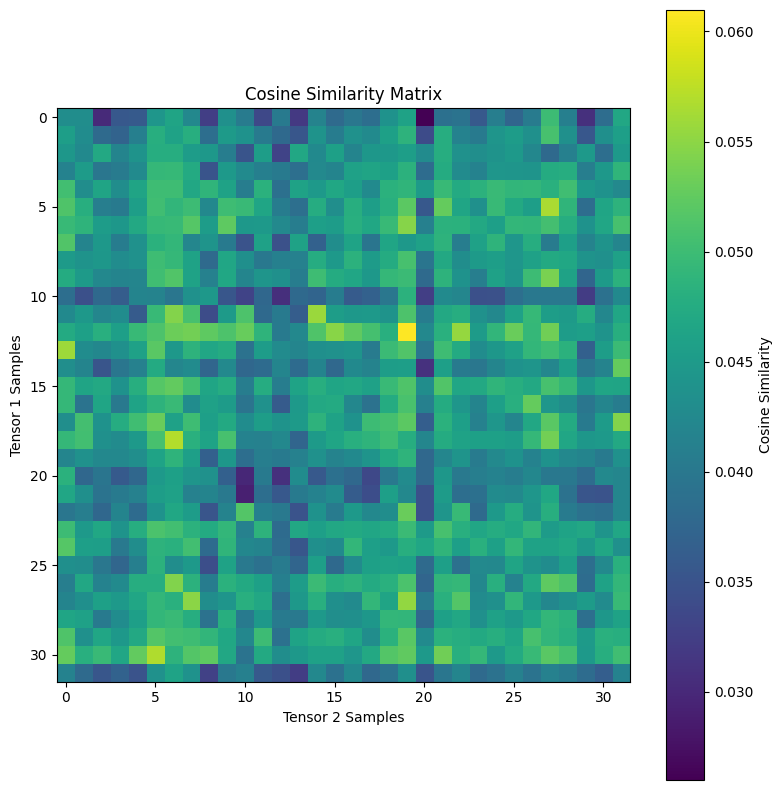

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt



# Compute the cosine similarity matrix
similarity_matrix = F.cosine_similarity(vision_multi.unsqueeze(1), text_multi.unsqueeze(0), dim=2)



# Plot the similarity matrix
plt.figure(figsize=(8, 8))
plt.imshow(similarity_matrix.detach().numpy(), cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Tensor 2 Samples')
plt.ylabel('Tensor 1 Samples')
plt.title('Cosine Similarity Matrix')
plt.tight_layout()
plt.show()
